In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [ ]:
#Read CSV
stores = pd.read_csv('/content/drive/MyDrive/DS 502 Project/walmart-recruiting-store-sales-forecasting/stores.csv')
features = pd.read_csv('/content/drive/MyDrive/DS 502 Project/walmart-recruiting-store-sales-forecasting/features.csv/features.csv', skipinitialspace= True)
walmart = pd.read_csv('/content/drive/MyDrive/DS 502 Project/walmart-recruiting-store-sales-forecasting/train.csv/train.csv', skipinitialspace= True)
test = pd.read_csv('/content/drive/MyDrive/DS 502 Project/walmart-recruiting-store-sales-forecasting/test.csv/test.csv', skipinitialspace= True)

In [ ]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
#Merge Data 
merged_df = walmart.merge(stores, how='left').merge(features,how = 'left')
#merged_test = test.merge(stores, how='left').merge(features,how = 'left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [ ]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [ ]:
# #Time transformation 
def time_trans(df):
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['WeekOfYear'] = pd.to_datetime(df['Date']).dt.isocalendar().week
    return df

time_trans(merged_df)
#time_trans(merged_test)

merged_df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,WeekOfYear
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,9


**EDA**

In [ ]:
weekly_sales = merged_df.groupby(['Year','WeekOfYear'], as_index = False).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales_2010 = merged_df.loc[merged_df['Year']==2010].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales_2011 = merged_df.loc[merged_df['Year']==2011].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales_2012 = merged_df.loc[merged_df['Year']==2012].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales_2010.info

<bound method DataFrame.info of             Weekly_Sales           
                    mean     median
WeekOfYear                         
5           16836.121997   7904.690
6           16352.056032   8365.095
7           16216.658979   8411.250
8           14899.549688   7235.800
9           15921.015727   7717.975
10          15546.850545   7529.550
11          15286.773578   7915.600
12          14975.894486   7345.130
13          17098.620298   8658.890
14          16050.589780   8006.270
15          15347.713003   7506.590
16          15252.114749   7644.980
17          14967.509147   7384.900
18          16542.716071   8467.060
19          15513.374470   8022.935
20          15499.865359   7847.140
21          16428.449453   8306.600
22          17246.922034   8596.010
23          16440.889213   8114.880
24          16281.041446   8127.630
25          15978.414909   8067.450
26          16769.792424   8117.290
27          16500.010117   7867.660
28          15940.675484   7828.

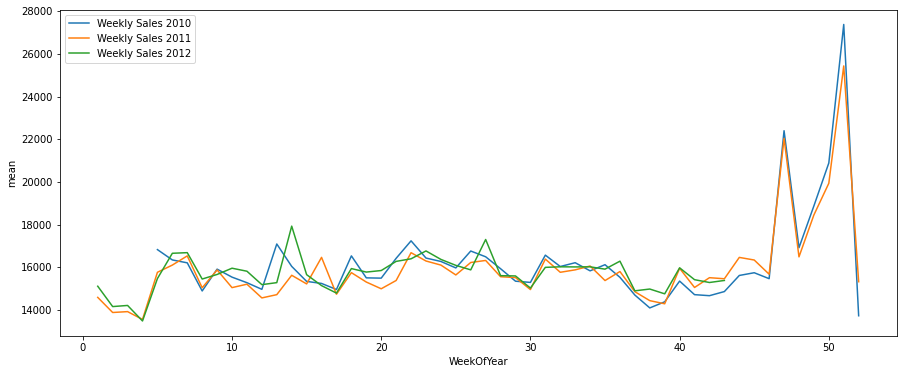

In [ ]:
plt.figure(figsize= (15,6))
sns.lineplot(x = weekly_sales_2010['Weekly_Sales']['mean'].index, y = weekly_sales_2010['Weekly_Sales']['mean'], label = 'Weekly Sales 2010')
sns.lineplot(x = weekly_sales_2011['Weekly_Sales']['mean'].index, y = weekly_sales_2011['Weekly_Sales']['mean'], label = 'Weekly Sales 2011')
sns.lineplot(x = weekly_sales_2012['Weekly_Sales']['mean'].index, y = weekly_sales_2012['Weekly_Sales']['mean'], label = 'Weekly Sales 2012')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales per Year')

Text(0.5, 1.0, 'Store size by type')

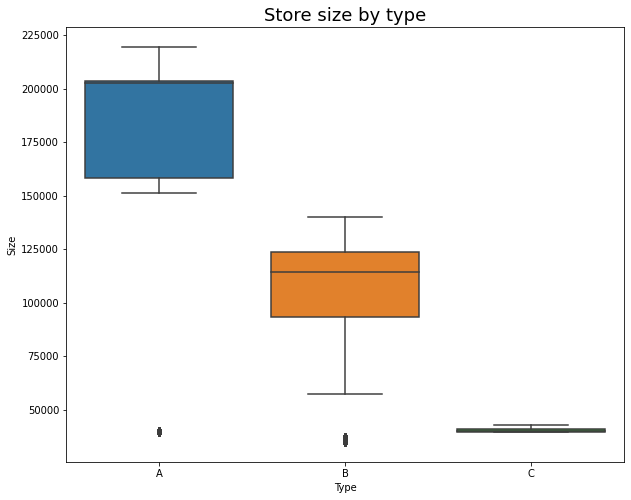

In [ ]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'Type', y = 'Size', data = merged_df)
plt.title('Store size by type', fontsize=18)

Text(0.5, 1.0, 'Weekly Sales per Store type')

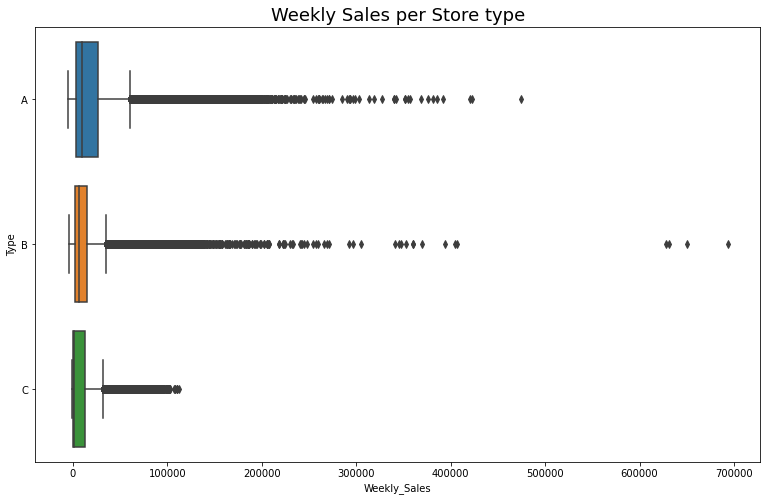

In [ ]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'Weekly_Sales', y = 'Type', data = merged_df, orient = 'h')
plt.title('Weekly Sales per Store type', fontsize=18)

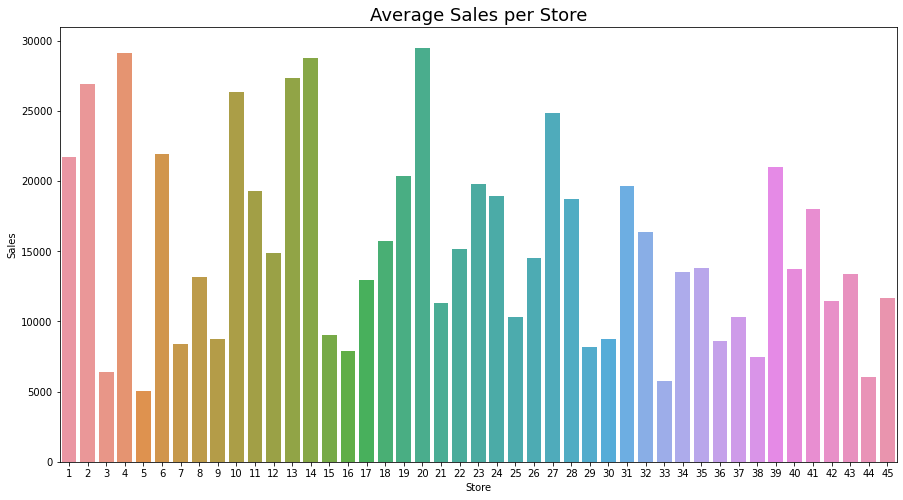

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x='Store', y='Weekly_Sales',data= merged_df,ci=None)
plt.title('Average Sales per Store', fontsize=18)
plt.ylabel('Sales')
plt.xlabel('Store')
plt.show()

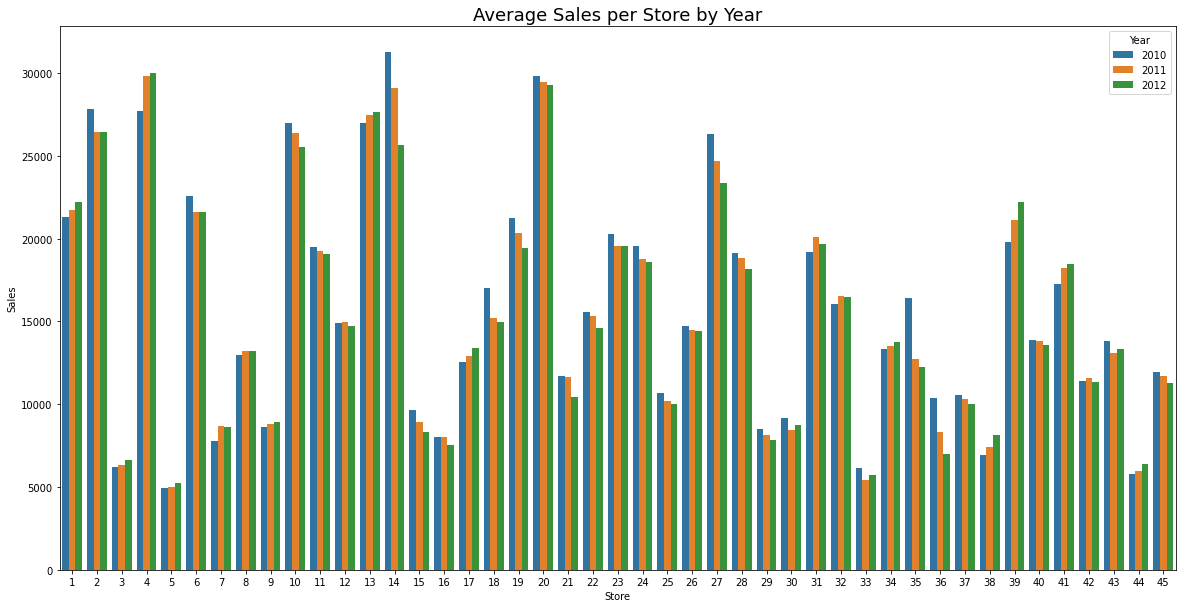

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot( x='Store', y='Weekly_Sales',data= merged_df, hue='Year',ci=None)
plt.title('Average Sales per Store by Year', fontsize=18)
plt.ylabel('Sales')
plt.xlabel('Store')
plt.show()

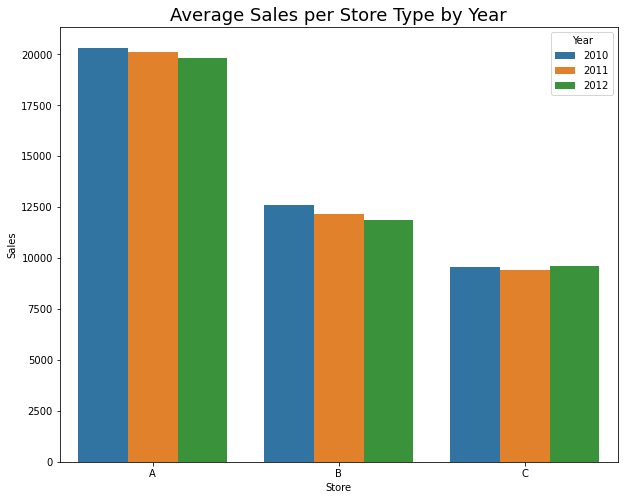

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot( x='Type', y='Weekly_Sales',data= merged_df, hue='Year', ci=None)
plt.title('Average Sales per Store Type by Year', fontsize=18)
plt.ylabel('Sales')
plt.xlabel('Store')
plt.show()

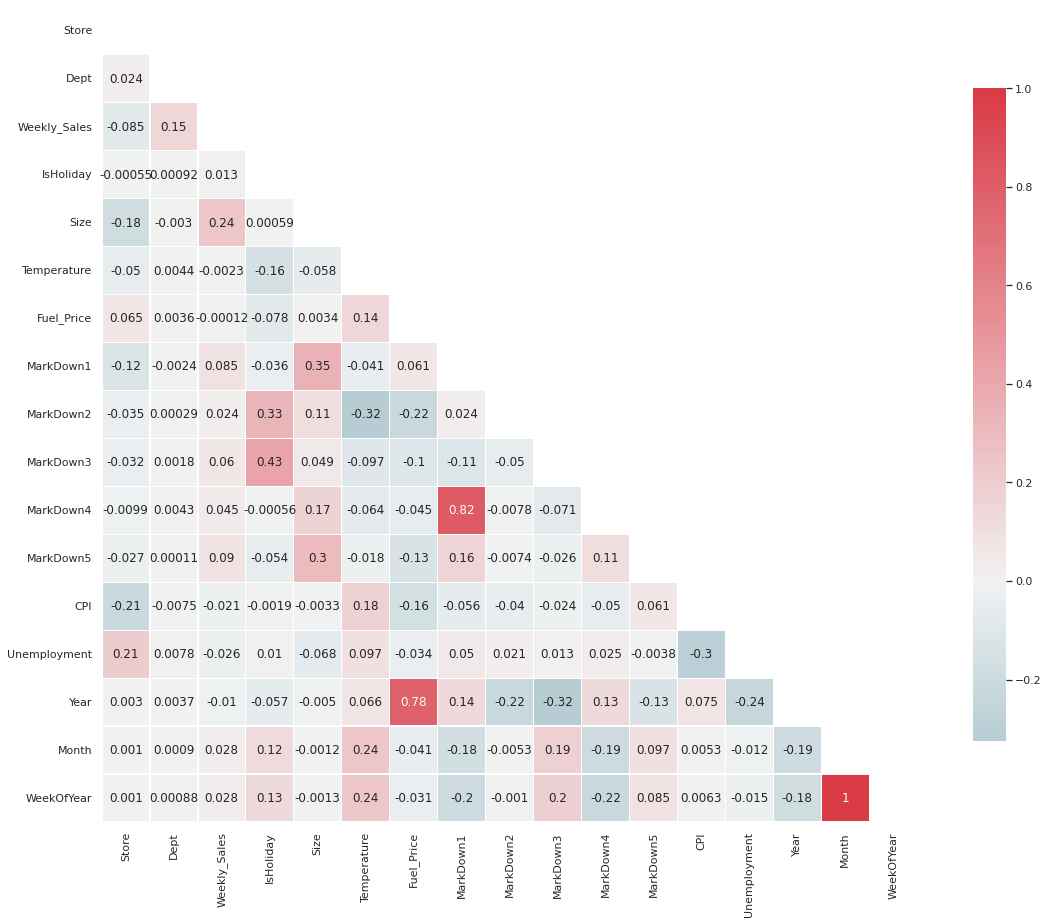

In [ ]:
sns.set(style="white")

corr = merged_df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8}, annot=True)
plt.show()

In [ ]:
#define X(independent),Y(dependent)
X = merged_df[['Store', 'Dept', 'Size', 'IsHoliday', 'Type',
       'Temperature', 'CPI', 'Unemployment', 'Year', 'Month']].copy()

y = merged_df['Weekly_Sales'].copy()

In [ ]:
num = ['Size',
       'Temperature','CPI', 'Unemployment', 'Year', 'Month']
cat = ['Store', 'Dept', 'IsHoliday', 'Type']
X[num].isna().sum()

Size            0
Temperature     0
CPI             0
Unemployment    0
Year            0
Month           0
dtype: int64

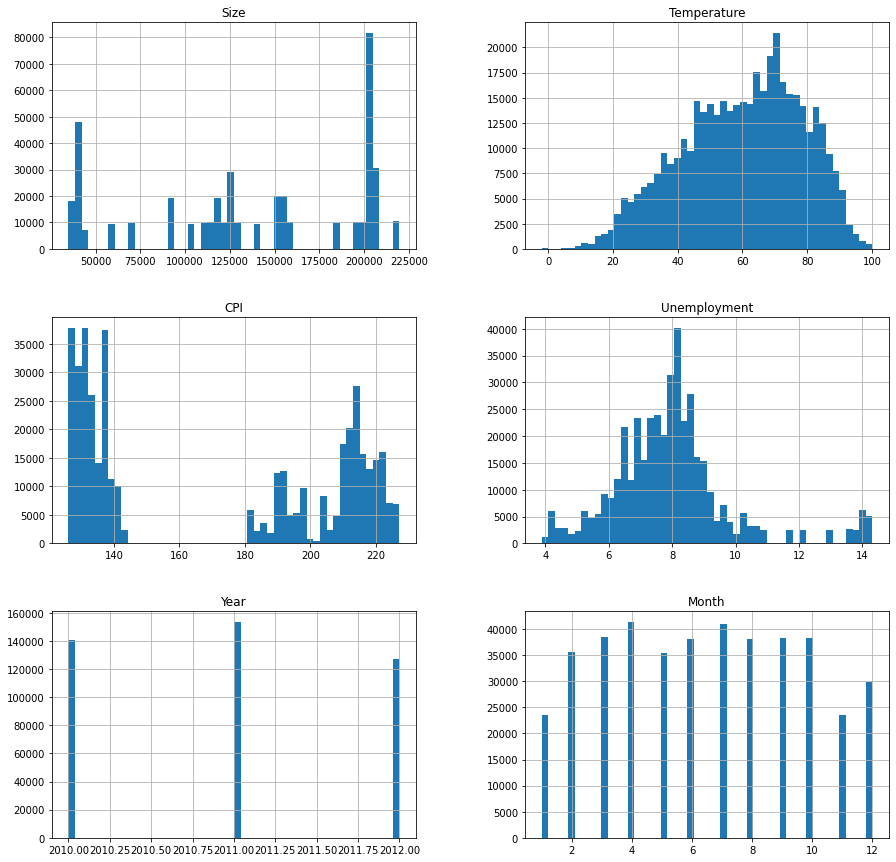

In [ ]:
#Check Distribution

X[num].hist(bins=50, figsize=(15,15))

plt.show()

In [ ]:
#Correlation w.r.t Weekly sales

df_corr = merged_df[merged_df.columns[:]].corr()['Weekly_Sales'][:]
df_corr = df_corr.drop("Weekly_Sales")
df_corr

Store          -0.085195
Dept            0.148032
IsHoliday       0.012774
Size            0.243828
Temperature    -0.002312
Fuel_Price     -0.000120
MarkDown1       0.085251
MarkDown2       0.024130
MarkDown3       0.060385
MarkDown4       0.045414
MarkDown5       0.090362
CPI            -0.020921
Unemployment   -0.025864
Year           -0.010111
Month           0.028409
WeekOfYear      0.027673
Name: Weekly_Sales, dtype: float64

In [ ]:
#Categorical Columns one hot encoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown = "ignore").fit(X[cat])
encoded_col = encoder.get_feature_names(cat)
X[encoded_col] = encoder.transform(X[cat]).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


KeyboardInterrupt: ignored

In [ ]:
X = pd.concat([X[num],X[encoded_col]],axis=1)

KeyError: ignored

In [ ]:
X.head()

,Store,Dept,Size,IsHoliday,Type,Temperature,CPI,Unemployment,Year,Month
0,1,1,0.1024,False,A,-0.716667,0.357955,0.142772,-0.5,-0.8
1,1,1,0.1024,True,A,-0.854348,0.359769,0.142772,-0.5,-0.8
2,1,1,0.1024,False,A,-0.802899,0.360353,0.142772,-0.5,-0.8
3,1,1,0.1024,False,A,-0.560145,0.360733,0.142772,-0.5,-0.8
4,1,1,0.1024,False,A,-0.564855,0.361112,0.142772,-0.5,-0.6


In [ ]:
X = pd.concat([X[num],X[cat]],axis=1)

In [ ]:
X.head()

,Size,Temperature,CPI,Unemployment,Year,Month,Store,Dept,IsHoliday,Type
0,151315,42.31,211.096358,8.106,2010,2,1,1,False,A
1,151315,38.51,211.242170,8.106,2010,2,1,1,True,A
2,151315,39.93,211.289143,8.106,2010,2,1,1,False,A
3,151315,46.63,211.319643,8.106,2010,2,1,1,False,A
4,151315,46.50,211.350143,8.106,2010,3,1,1,False,A


In [ ]:
X['IsHoliday'] = X['IsHoliday'].astype('str').map({'True':0,'False':1})
X.Type = X.Type.map({'A':2,'B':1,'C':0})

In [ ]:
#Scaling (Normalization)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X)
X[X.columns] = scaler.transform(X)

In [ ]:
X.head()

,Size,Temperature,CPI,Unemployment,Year,Month,Store,Dept,IsHoliday,Type
0,0.630267,0.434149,0.840500,0.405118,0.0,0.090909,0.0,0.0,1.0,1.0
1,0.630267,0.396967,0.841941,0.405118,0.0,0.090909,0.0,0.0,0.0,1.0
2,0.630267,0.410861,0.842405,0.405118,0.0,0.090909,0.0,0.0,1.0,1.0
3,0.630267,0.476419,0.842707,0.405118,0.0,0.090909,0.0,0.0,1.0,1.0
4,0.630267,0.475147,0.843008,0.405118,0.0,0.181818,0.0,0.0,1.0,1.0


# Tree-based Models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 101)

In [ ]:
def eval_metric(predict):
    scores = pd.DataFrame([mean_absolute_error(y_test, predict),
                           mean_squared_error(y_test, predict, squared = False),
                          r2_score(y_test, predict),
                          r2_score(y_test, predict, multioutput='variance_weighted')],columns=['score'],
                          
                          index=['MAE','RMSE','R2 score','Adjusted R2'])
    return scores

In [ ]:
def model_eval(model, modelname):   
    modelname = model()
    modelname.fit(X_train, y_train)
    preds = modelname.predict(X_test)
    try:
        feat_imp = modelname.feature_importances_
        indices = np.sort(feat_imp)[:10]
        plt.figure(figsize = (10,6))
        plt.bar(X_train.columns, feat_imp)
        plt.title('Feature Importance plot')
    except:
        pass
    return eval_metric(preds)

[15:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,score
MAE,6931.718933
RMSE,11577.411970
R2 score,0.738232
Adjusted R2,0.738232


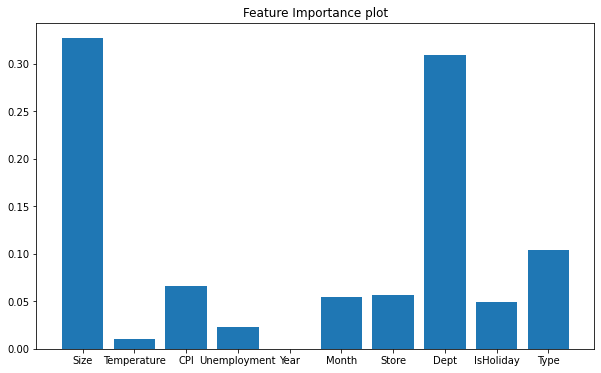

In [ ]:
model_eval(XGBRegressor,'xgb')

In [ ]:
xgb = XGBRegressor() 
xgb.fit(X_train, y_train) 
fea_imp = pd.Series(xgb.feature_importances_, index=X_train.columns)
print(fea_imp.sort_values(ascending=False).head(15))


[03:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Dept_95    0.100148
Dept_92    0.099275
Dept_38    0.071665
Dept_90    0.050774
Dept_2     0.047368
Dept_72    0.046562
Dept_40    0.042899
Month      0.041717
Dept_91    0.032573
Dept_8     0.022571
Dept_13    0.021123
Dept_94    0.020425
Type_B     0.018320
Size       0.018221
Dept_7     0.017990
dtype: float32


In [ ]:
etr = ExtraTreesRegressor() 
etr.fit(X_train, y_train) 
fea_imp = pd.Series(etr.feature_importances_, index=X_train.columns)
print(fea_imp.sort_values(ascending=False).head(15))

Size          0.106519
Dept_92       0.104138
Dept_95       0.091784
Dept_38       0.066466
Type_A        0.046078
Dept_72       0.038955
Type_B        0.034860
WeekOfYear    0.032124
Dept_40       0.032021
Dept_90       0.031955
Dept_2        0.029770
Month         0.023726
Dept_91       0.021499
Store_10      0.019673
Dept_94       0.018144
dtype: float64


,score
MAE,1722.265364
RMSE,4513.904843
R2 score,0.960208
Adjusted R2,0.960208


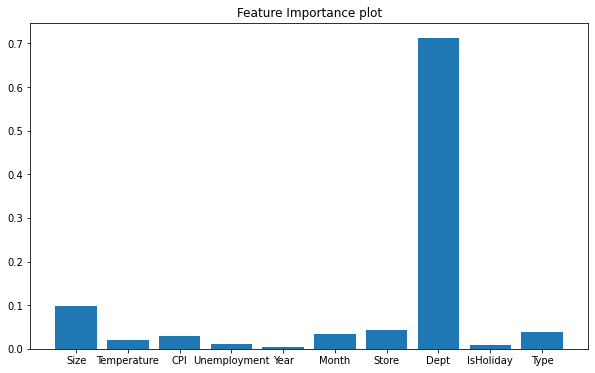

In [ ]:
model_eval(ExtraTreesRegressor,'ext')

In [ ]:
ext = ExtraTreesRegressor()
ext.fit(X_train,y_train.values.ravel())
ext_pred = ext.predict(X_test)
#After tuning Evaluation 
eval_metric(ext_pred)

,score
MAE,1724.788993
RMSE,4549.400092
R2 score,0.959579
Adjusted R2,0.959579


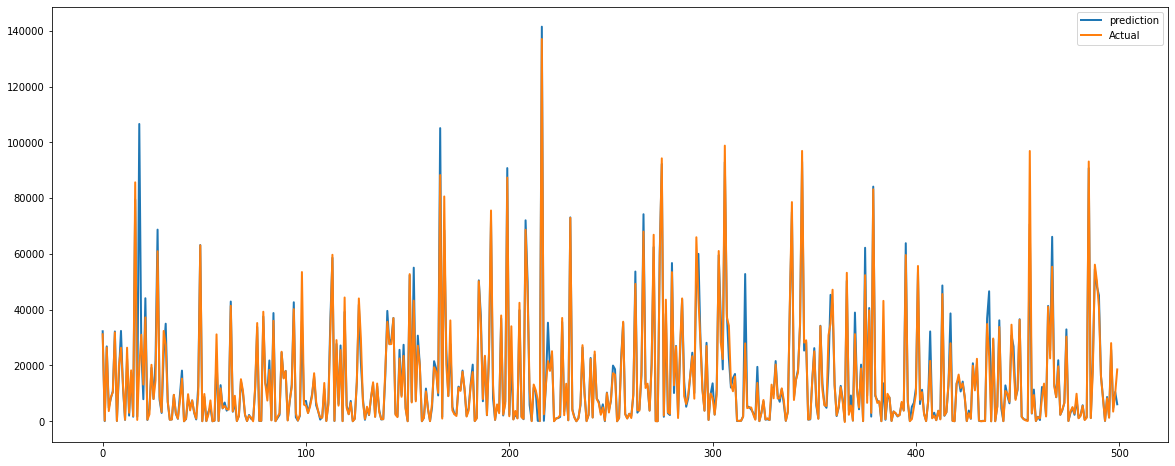

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(ext.predict(X_test[25000:25500]), label="prediction", linewidth=2.0)
plt.plot(y_test[25000:25500].values, label="Actual", linewidth=2.0)
plt.legend(loc="best")

In [ ]:
etr = ExtraTreesRegressor() 
etr.fit(X_train, y_train) 
fea_imp = pd.Series(etr.feature_importances_, index=X_train.columns)
print(fea_imp.sort_values(ascending=False).head(15))

,score
MAE,1647.963860
RMSE,4290.232698
R2 score,0.964054
Adjusted R2,0.964054


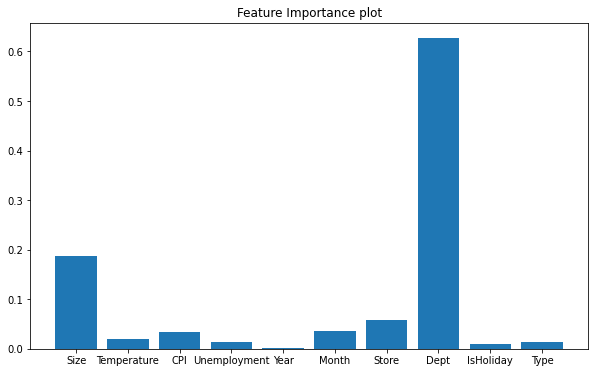

In [ ]:
#Random Forest
model_eval(RandomForestRegressor,'rf')

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train.values.ravel())
rf_pred = rf.predict(X_test)
#After tuning Evaluation 
eval_metric(rf_pred)

,score
MAE,1649.945696
RMSE,4318.313782
R2 score,0.963581
Adjusted R2,0.963581


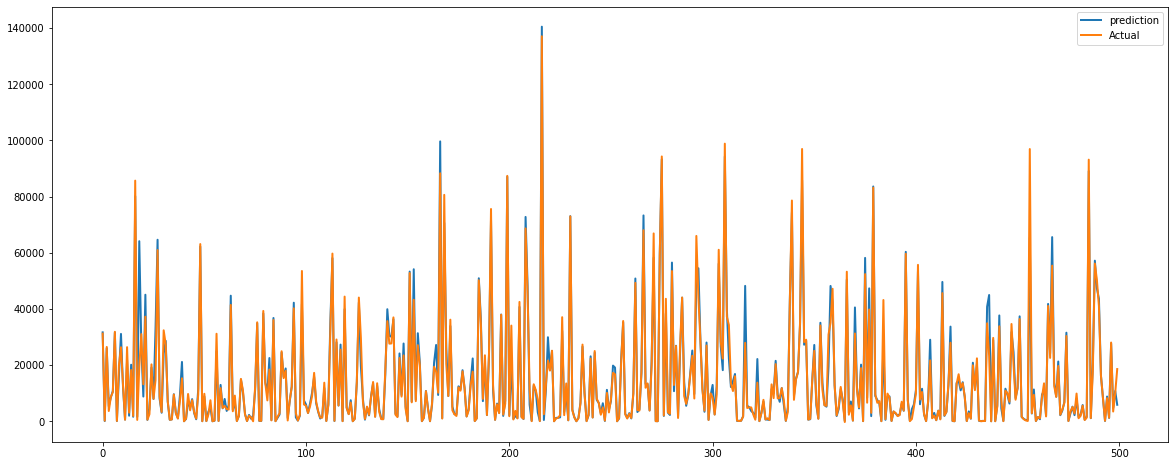

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(rf.predict(X_test[25000:25500]), label="prediction", linewidth=2.0, )
plt.plot(y_test[25000:25500].values, label="Actual", linewidth=2.0)
plt.legend(loc="best")

In [ ]:
rf = RandomForestRegressor() 
rf.fit(X_train, y_train) 
index=X_train.columns
fea_imp = pd.Series(rf.feature_importances_, index)
print(fea_imp.sort_values(ascending=False).head(15))

Dept            0.627045
Size            0.186724
Store           0.059461
Month           0.035619
CPI             0.034605
Temperature     0.019009
Type            0.013874
Unemployment    0.012764
IsHoliday       0.009235
Year            0.001665
dtype: float64


In [ ]:
X_train


,Size,Temperature,CPI,Unemployment,Year,Month,Store,Dept,IsHoliday,Type
129684,0.557846,0.318116,0.003475,0.521713,-0.5,0.6,-0.363636,-0.446429,-1.0,0.0
136020,0.557846,-0.757609,0.087162,0.331945,0.5,-1.0,-0.363636,0.750000,0.0,0.0
322819,0.164853,0.120290,-0.637397,0.578822,0.5,0.8,0.545455,-0.357143,0.0,0.0
333929,-0.335143,0.297826,-0.569216,0.591910,-0.5,0.4,0.590909,-0.214286,0.0,-1.0
162560,-0.431527,-0.802536,-0.635936,-1.391434,0.5,0.8,-0.227273,0.017857,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
311895,0.577218,0.184058,0.101376,0.684711,-0.5,0.6,0.454545,0.767857,0.0,0.0
136767,0.557846,0.381522,0.112273,0.486615,0.5,0.4,-0.363636,0.857143,0.0,0.0
204614,0.000000,0.609420,0.423453,-0.008328,0.0,0.6,-0.045455,0.535714,0.0,-1.0
214539,-0.189314,-0.581884,-0.580272,0.248067,-0.5,-0.6,0.000000,0.660714,0.0,-1.0


# Ridge and Elastic Net Regression Models 



In [ ]:
# Ridge Model Progressive Evaluation

tscv = TimeSeriesSplit()

TimeSeriesSplit(max_train_size=None, n_splits=5)

MSE_ridge = []
MAE_ridge = []
R2_ridge = []

n = 300
lambdas = np.logspace(-2, 10, n)

ridge_cv = RidgeCV(alphas = lambdas, scoring = 'neg_mean_squared_error', normalize = True, cv= 5)
ridge_cv.fit(X, y)


for train_index, test_index in tscv.split(X):

  print('TRAIN:', train_index, 'TEST:', test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  ridge_model = Ridge(alpha = ridge_cv.alpha_, normalize= True)
  ridge_model.fit(X_train, y_train)
  pred = ridge_model.predict(X_test)
  
  MSE_ridge.append(mean_squared_error(y_test, pred))
  MAE_ridge.append(mean_absolute_error(y_test, pred))
  R2_ridge.append(r2_score(y_test, pred))

In [ ]:
print (" Mean Square Error is :", MSE_ridge)
print (" Mean Absolute Error is :", MAE_ridge)
print (" Mean Square Error is :", MSE_ridge)

In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

# Elastic Net Regression

tscv = TimeSeriesSplit()

TimeSeriesSplit(max_train_size=None, n_splits=5)

MSE_EN = []
MAE_EN = []
R2_EN = []

for train_index, test_index in tscv.split(X):
  print('TRAIN:', train_index, 'TEST:', test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  EN_cv = ElasticNetCV(alphas = lambdas, scoring = 'neg_mean_squared_error', normalize = True, cv= 5)
  En_cv.fit(X_train, y_train)

  ridge_model = ElasticNet(alpha = EN_cv.alpha_, normalize= True)
  ridge_model.fit(X_train, y_train)
  pred = ridge_model.predict(X_test)
  
  MSE_EN.append(mean_squared_error(y_test, pred))
  MAE_EN.append(mean_absolute_error(y_test, pred))
  R2_EN.append(r2_score(y_test, pred))

# Lasso Regression





In [ ]:
##LASSO obtain best alpha for the model through CV
lassocv=LassoCV(eps=1e-3,cv=5,random_state=1,max_iter=200)
lassocv.fit(X,y)
bestalpha=lassocv.alphas_[np.argmin(lassocv.mse_path_.mean(-1))]

In [ ]:
#use best alpha to obtain the models performance
lassomod = Lasso(random_state=3,alpha=bestalpha)
tsf = TimeSeriesSplit(n_splits=5)
mse = []
mae =[]
r2 = []
adj_r2 = []
mods = []
for train_index, test_index in tsf.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lassomod.fit(x_train, y_train)
    y_pred = lassomod.predict(x_test)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))
    mods.append(lassomod)
print('Metrics for Lasso Model:')
print('Mean Root Square Error is :', np.mean(mse)**0.5)
print('Mean Absolute Error is :', np.mean(mae))
print('Mean Square Error is :', np.mean(r2))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+11, tolerance: 4.679e+09
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
